In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys, os
sys.path.append('../')
from data_handling import Container,load_data,Normalize,Denormalize
from plot_style.style_prab import load_preset,figsize,cmap_nicify
from plot_style.style_prab import colors as colors_preset
from train_ensemble import train, NN, Loss
from analysis.scan_model import median,quantile
load_preset(scale=1,font_path='../plot_style/font')
import pickle
mymap = cmap_nicify(cmap='YlGnBu_r',idx_white=1,size_white=50)
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from scipy.odr import ODR,RealData,Model
import pickle
from ensemble.Bregressor_ import BaggingRegressor
from ensemble.utils import io

def run_ODR(x,y,sx=None,sy=None):
    def f(B, x):
        return B[0]*x + B[1]

    if not sx: 
        sx = 1
    else:
        sx = sx
        
    if not sy: 
        sy = 1
    else:
        sy = sy
    
    mydata = RealData(x/x.std(), y/y.std(), sx=sx, sy=sy)
    linear = Model(f)
    myodr = ODR(mydata, linear, beta0=[1., 2.])
    myoutput = myodr.run()
    
    beta = myoutput.beta
    beta[0] *= y.std()/x.std()
    beta[1] *= y.std()
    return beta 


def confidence_ellips(x,y,std=2.):
    cov = np.cov(x, y)
    val, rot = np.linalg.eig(cov)
    val = np.sqrt(val)
    center = np.mean([x, y], axis=1)[:, None]

    t = np.linspace(0, 2.0 * np.pi, 1000)
    xy = np.stack((np.cos(t), np.sin(t)), axis=-1)*std

    return (rot @ (val * xy).T + center)


matplotlib preset loaded


In [2]:
model_path = '../models/'

with open(f'{model_path}config.pkl', 'rb') as fp:
    config = pickle.load(fp)
    norm = config['norm']

if isinstance(config['model'],list):
    model = nn.ModuleList(config['model'])
    ensemble = BaggingRegressor(estimator=model,               # estimator is your pytorch model
                                n_estimators=config['estimators'],
                                cuda=False,)
    ensemble.set_criterion(config['loss_fun'])
    io.load(ensemble, model_path)
    
trainset, testset, _ = load_data(
config["path"],
config["inputs"],
config["outputs"],
samples=config["samples"],
ratio=config['ratio'],
start_ind=config["start_ind"],
norm=norm,
random=False,
)

trainset = Container(trainset)
trainset.x = Denormalize(trainset.x.to('cpu'),norm[0])  
trainset.y = Denormalize(trainset.y.to('cpu'),norm[1])  


# conversion factors
c_zfoc = ((162*1e3)/6.9)

xdata = trainset.x[:,8].detach().numpy()
zfocm = xdata.mean()
zfoc = (xdata-zfocm)*c_zfoc

xdata = trainset.x[:,4].detach().numpy()
wlm = xdata.mean()
wl = xdata - wlm



# extract model surface
x_ = torch.linspace(-5,5,100)
y_ = torch.linspace(-5,5,100)
grid_x, grid_y = torch.meshgrid(x_, y_, indexing='ij')
x = torch.zeros(100**2,14)
# index of xfoc and wavelength
x[:,4] = grid_y.flatten()
x[:,8] = grid_x.flatten()

y_pred = median(x,ensemble).detach().numpy()
y_pred = Denormalize(y_pred,norm[1])
y_pred = y_pred.reshape(100,100,5)

x = Denormalize(x,norm[0])
x = x.reshape(100,100,14)

y = (x[:,0,8].detach().numpy()-zfocm)*c_zfoc
x = x[0,:,4].detach().numpy()-wlm


In [3]:
trainset, testset, _ = load_data(
config["path"],
config["inputs"],
config["outputs"],
samples=100000,#config['samples'],
ratio=config['ratio'],
start_ind=config["start_ind"],
norm=norm,
random=False,
)

trainset = Container(trainset)
trainset.x = Denormalize(trainset.x.to('cpu'),norm[0])  
trainset.y = Denormalize(trainset.y.to('cpu'),norm[1])  


xdata = trainset.x[:,[4,8]]
ydata = trainset.y


zfocm = xdata[:,1].mean()
zfoc = ((xdata[:,1]-zfocm)*c_zfoc).detach().numpy()

wlm = xdata[:,0].mean()
wl = (xdata[:,0]-wlm).detach().numpy()


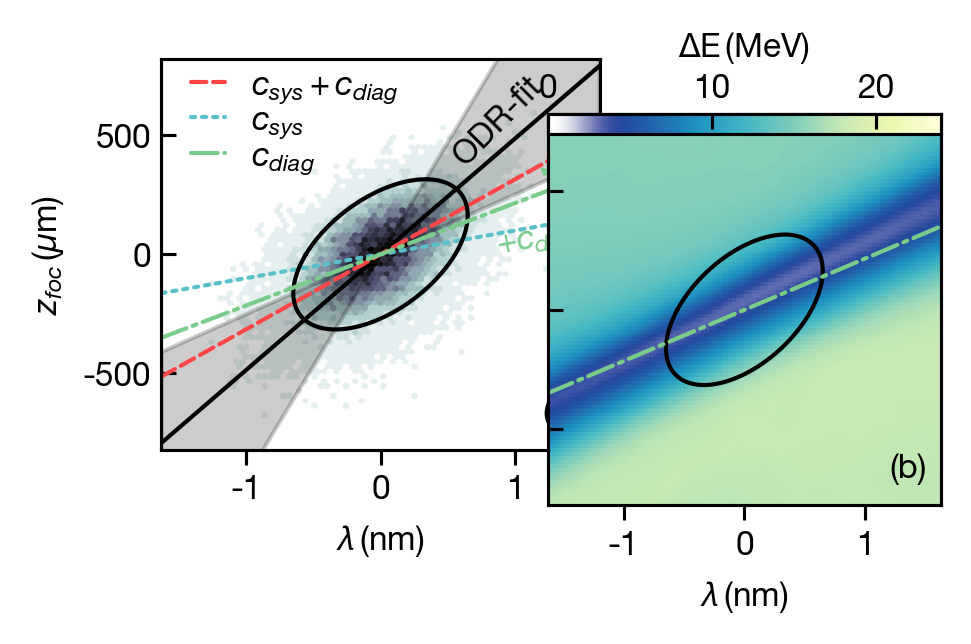

In [13]:
labels = ['amp2_spec_mean','3']
colors = colors_preset
elim = [0,24]


fig_w = figsize['inch']['column_width']
fig,ax = plt.subplots(1,2,figsize=(fig_w,fig_w*0.5),constrained_layout=False)

k = np.polyfit(wl,zfoc,1)
chrom = 100 #mu/nm
k_odr = run_ODR(wl,zfoc)
k_odr_h = run_ODR(wl,zfoc,sx=1,sy=100)
k_odr_l = run_ODR(wl,zfoc,sx=100,sy=1)

k_sym = 235
k_est = 215

im = ax[1].pcolormesh(x,y,y_pred[:,:,1],cmap=mymap,rasterized=False,
                     vmin=elim[0],vmax=elim[1],
                        antialiased=True, 
                        linewidth=0.0,alpha=1)

ax[0].hexbin(wl,zfoc,bins=15,gridsize=70,cmap='bone_r',linewidth=0.1,extent=[x.min(),x.max(),y.min(),y.max()])
ax[0].plot(x,x*k_odr[0]+k_odr[1],'k')
ax[0].fill_between(x,x*k_odr_l[0]+k_odr_l[1],x*k_odr_h[0]+k_odr_h[1],color='k',alpha=0.2)


ax[0].plot(x,x*(chrom+k_est),'--',color=colors[0],label=r'$c_{sys}+c_{diag}$')

ax[0].plot(x,x*chrom,':',color=colors[1],label=r'$c_{sys}$')

ellipse = confidence_ellips(wl,zfoc,std=2.)

ax[0].plot(*ellipse,'k')
ax[1].plot(*ellipse,'k')
ax[1].plot(x,x*k_est,'-.',color=colors[2],label=r'$c_{diag}$')
ax[0].plot(x,x*k_est,'-.',color=colors[2],label=r'$c_{diag}$')

for i in range(2):
    ax[i].set_xlim(x.min(),x.max())
    ax[i].set_ylim(y.min(),y.max())
    ax[i].set_xlabel(r'$\lambda\,$(nm)')
    ax[i].tick_params(
    axis='y',        
    direction='in',)




ax[1].tick_params(
    axis='y',        
    which='both',
    left=True,
    labelleft=False,)
ax[0].set_ylabel(r'$z_{foc}\,$($\mu$m)')   
ax[0].legend(frameon=False,labelspacing=.0,handlelength=1.,loc='upper left',bbox_to_anchor=(0.0,1.05))
#ax[1].legend(frameon=False)

style = "Simple, head_width=1.5, head_length=1.5"
a = patches.FancyArrowPatch((1.3, 120), (1.15, 380),
                             connectionstyle="arc3,rad=.4", color=colors[2], arrowstyle=style,lw=0.5)
ax[0].add_patch(a)
ax[0].text(0.85, 5, r'$+c_{diag}$',color=colors[2], rotation=10)
ax[0].text(0.5, 380, r'ODR-fit',color='k', rotation=45)
ax[0].text(1.2, -700, r'(a)',color='k')
ax[1].text(1.2, -700, r'(b)',color='k')

#ax[0].set_aspect(np.diff(ax[0].get_xlim())/np.diff(ax[0].get_ylim()))
#ax[1].set_aspect(np.diff(ax[1].get_xlim())/np.diff(ax[1].get_ylim()))
#fig.tight_layout()

fig.subplots_adjust(wspace=0.0,hspace=0.0)

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width, box.height])
    
#divider = make_axes_locatable(ax[1])
#cax = divider.append_axes('top', size='3%', pad=0.00)
cax = plt.axes([box.x0, box.height*0.95+box.y0, box.width, box.height*0.05])
cb = fig.colorbar(im, cax=cax, orientation='horizontal')
cb.ax.tick_params('x',
                  top=True,      # ticks along the bottom edge are off
                  labeltop=True,
                  bottom = False,
                  labelbottom = False,
                  direction='in')

cax.set_xlabel(r'$\Delta$E$\,$(MeV)')
cax.xaxis.set_label_position('top')

plt.savefig('figures/chromatic_error.png',bbox_inches='tight')

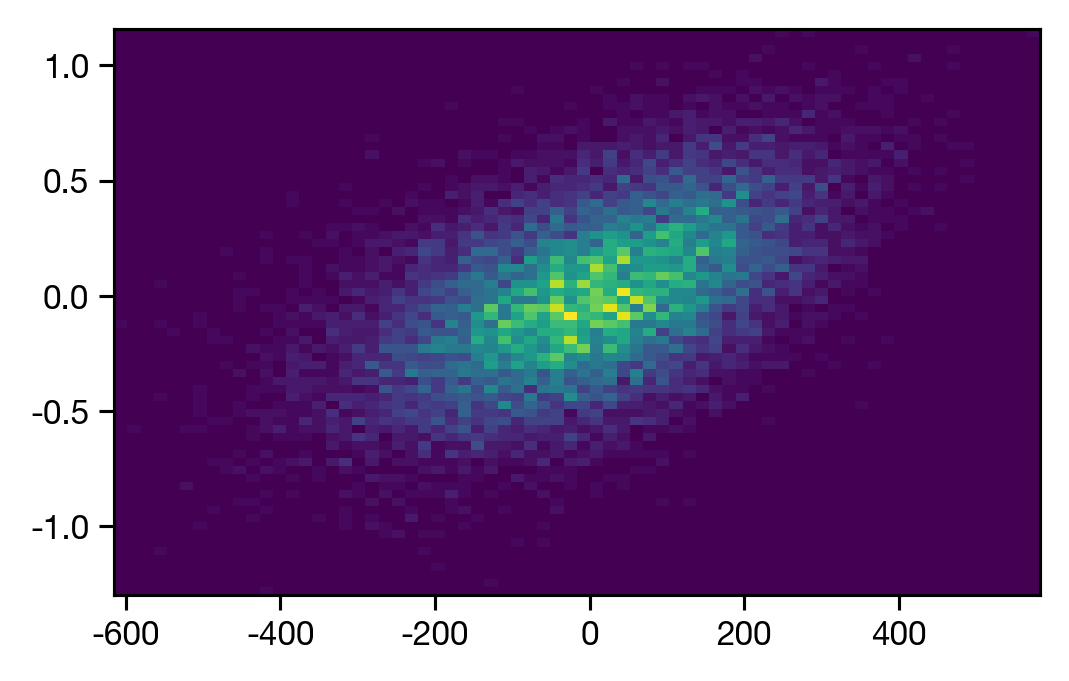

In [136]:
plt.hist2d(zfoc,wl,bins=70);

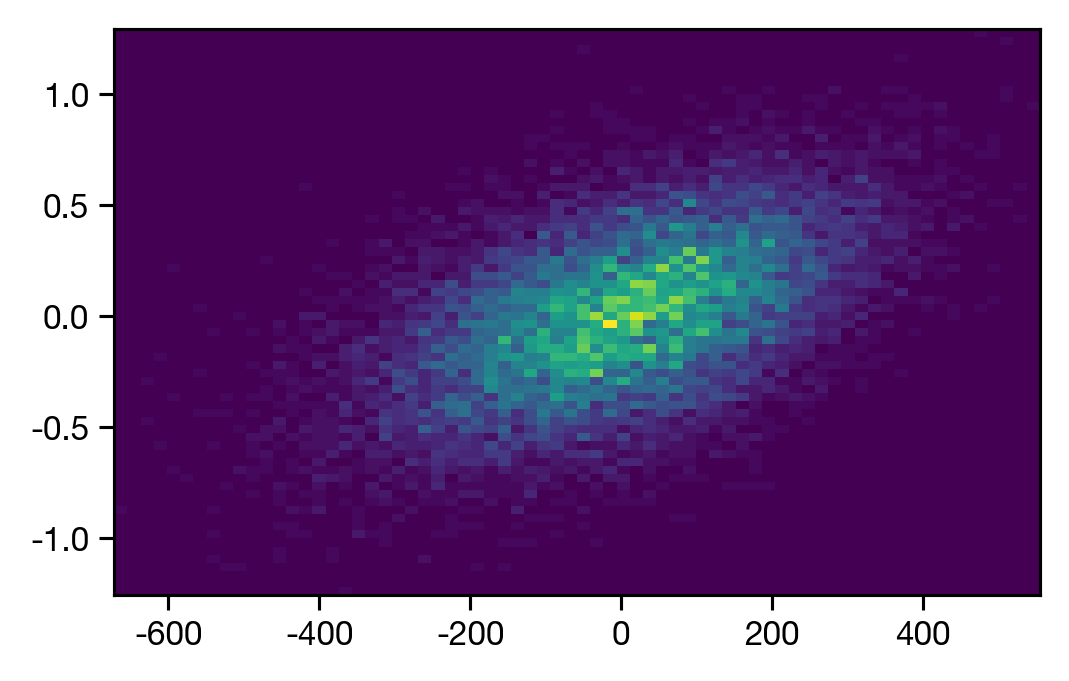

In [139]:
plt.hist2d(zfoc,wl,bins=70);